In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
import time

import seaborn as sns

In [2]:
# parser v1
# parse records to list of dicts
# values mostly are strings
# easy to iterate through records
records = []
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        record = {}
        record['timestamp'] = int(components[0])
        record['displayed'] = components[1]
        record['clicked'] = int(components[2])
        # not using user feature
        record['user_features'] = []
        for i in range(4, len(components)):
            if components[i].startswith('|'):
                n = i
                break
            #record['user_features'].append(int(components[i]))
        record['pool'] = components[n:]    
        records.append(record)

In [3]:
len(records)

1607525

In [88]:
records[0]

{'clicked': 0,
 'displayed': 'id-560620',
 'pool': ['|id-552077',
  '|id-555224',
  '|id-555528',
  '|id-559744',
  '|id-559855',
  '|id-560290',
  '|id-560518',
  '|id-560620',
  '|id-563115',
  '|id-563582',
  '|id-563643',
  '|id-563787',
  '|id-563846',
  '|id-563938',
  '|id-564335',
  '|id-564418',
  '|id-564604',
  '|id-565364',
  '|id-565479',
  '|id-565515',
  '|id-565533',
  '|id-565561',
  '|id-565589',
  '|id-565648',
  '|id-565747',
  '|id-565822'],
 'timestamp': 1317513291,
 'user_features': []}

In [38]:
# parser that watches article lifespans
lives = {}
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        for component in components:
            if component.startswith('|id-'):
                timestamp = int(components[0])
                article = component[1:]
                if article in lives.keys():
                    lives[article][1] = timestamp
                else:
                    lives[article] = [timestamp, timestamp]

In [55]:
# checking
l = {}
with open('Webscope_R6B/ydata-fp-td-clicks-v2_0.20111002') as f:
    for line in f.readlines():
        components = line.strip().split(' ')
        for component in components:
            if component.startswith('|id-'):
                timestamp = int(components[0])
                article = component[4:]
                if article in l.keys():
                    if l[article][-1] != timestamp:
                        l[article].append(timestamp)
                else:
                    l[article] = [timestamp]

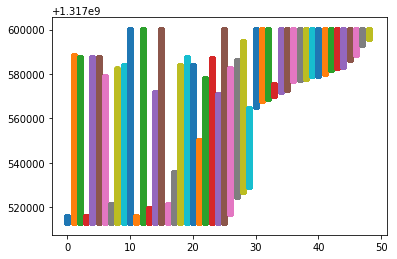

In [64]:
for n,i in enumerate(l.items()):
    plt.scatter([n]*len(i[1]), i[1])

In [100]:
lives.keys()

dict_keys(['id-552077', 'id-555224', 'id-555528', 'id-559744', 'id-559855', 'id-560290', 'id-560518', 'id-560620', 'id-563115', 'id-563582', 'id-563643', 'id-563787', 'id-563846', 'id-563938', 'id-564335', 'id-564418', 'id-564604', 'id-565364', 'id-565479', 'id-565515', 'id-565533', 'id-565561', 'id-565589', 'id-565648', 'id-565747', 'id-565822', 'id-565930', 'id-566013', 'id-566022', 'id-566092', 'id-560805', 'id-564371', 'id-562265', 'id-565980', 'id-566431', 'id-566439', 'id-559833', 'id-566541', 'id-562374', 'id-566587', 'id-566478', 'id-566573', 'id-566602', 'id-562637', 'id-566631', 'id-566689', 'id-566726', 'id-566825', 'id-566838'])

In [246]:
# average lifespan
sum(map(lambda x:x[1]-x[0], lives.values())) / len(lives)

40648.4693877551

In [125]:
life_length = []
alive = []
for v in lives.values():
    alive.append(np.arange(v[0], v[1]+1))
    life_length.append(v[1]-v[0])

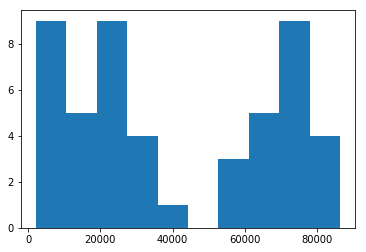

In [122]:
plt.hist(life_length)
pass

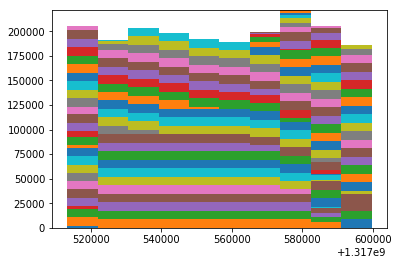

In [128]:
# number of arms available through out the timestamps
plt.hist(alive, histtype='barstacked')
pass

In [ ]:
estimated

In [ ]:
# offline simulation for AG_L
# slow but more accurate version
# comsumes much more records


def AG_L2(n=1000,k=1, m=25, life_threshold=.1, records=records, lives=lives, verbose=True):
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    def get_young_arms():
        time = records[i]['timestamp']
        born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
        life_rank = sorted(born, key= lambda x: x[1][2], reverse= True) # sort born articles by their expiring date
        young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
        return list(zip(*young))[0]
    
    def get_best_arm():
        time = records[i]['timestamp']
        available = filter(lambda x:lives[x[0]][1] >= time, X.items())
        best = max(available, key= lambda x:x[1][0]/x[1][1])
        return best
    
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        record = records[i]
        displayed = record['displayed']
        clicked = record['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    try:
        while t<=n:
            best = get_best_arm()
            X_max = best[1][0]/best[1][1]
            if np.random.binomial(1, min(1, X_max*k)): # exploit
                n_exploit += 1
                while records[i]['displayed'] != get_best_arm()[0]:
                    i += 1
            else: # explore
                n_explore += 1
                while records[i]['displayed'] != np.random.choice(get_young_arms(), size=1):
                    i += 1
                    
            if verbose:
                if i%1000==0:
                    print(t, i)
                
            record = records[i]
            rewards += record['clicked']
            for update in record['pool']:
                lives[update[1:]][2] = record['timestamp']
            
            X[record['displayed']] = X.get(record['displayed'], np.array([0, 0])) + np.array([record['clicked'], 1])
            t += 1
            i += 1
            
    except IndexError:
        print('running out of records')
        return
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)


    return rewards

In [65]:
records[0]['pool']

['|id-552077',
 '|id-555224',
 '|id-555528',
 '|id-559744',
 '|id-559855',
 '|id-560290',
 '|id-560518',
 '|id-560620',
 '|id-563115',
 '|id-563582',
 '|id-563643',
 '|id-563787',
 '|id-563846',
 '|id-563938',
 '|id-564335',
 '|id-564418',
 '|id-564604',
 '|id-565364',
 '|id-565479',
 '|id-565515',
 '|id-565533',
 '|id-565561',
 '|id-565589',
 '|id-565648',
 '|id-565747',
 '|id-565822']

In [71]:
# offline simulation for AG_L
# slow but more accurate version
# comsumes much more records


def AG_L2(n=1000,k=1, m=25, life_threshold=.1, records=records, lives=lives, verbose=True):
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    def get_young_arms():
        time = records[i]['timestamp']
        born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
        life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
        young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
        return list(zip(*young))[0]
    
    def get_best_arm():
        time = records[i]['timestamp']
        available = filter(lambda x:lives[x[0]][1] >= time, X.items())
        best = max(available, key= lambda x:x[1][0]/x[1][1])
        return best
    
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        record = records[i]
        displayed = record['displayed']
        clicked = record['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    try:
        while t<=n:
            best = get_best_arm()
            X_max = best[1][0]/best[1][1]
            if np.random.binomial(1, min(1, X_max*k)): # exploit
                n_exploit += 1
                while records[i]['displayed'] != get_best_arm()[0]:
                    i += 1
            else: # explore
                n_explore += 1
                while records[i]['displayed'] != np.random.choice(get_young_arms(), size=1):
                    i += 1
                    
            if verbose:
                if i%1000==0:
                    print(t, i)
                
            record = records[i]
            rewards += record['clicked']
            X[record['displayed']] = X.get(record['displayed'], np.array([0, 0])) + np.array([record['clicked'], 1])
            t += 1
            i += 1
            
    except IndexError:
        print('running out of records')
        return
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)


    return rewards

In [27]:
AG_L2(10000, life_threshold=.1)

609 16000
1248 33000
1818 48000
2290 59000
2635 67000
2728 69000
2780 70000
2828 71000
3370 83000
5539 135000
6066 147000
6268 152000
6603 160000
6932 167000
7568 182000
8209 195000
8883 208000
# exploit: 560
# explore: 9415
# records: 231161
max expectation: 0.04753486544883127


472

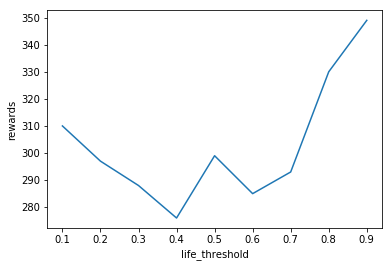

In [67]:
# compare by birth
x = []
y = []
for b in np.arange(0.1,1.,.1):
    x.append(b)
    y.append(AG_L2(n=10000,life_threshold=b, verbose=False))
plt.plot(x,y)
plt.xlabel('life_threshold')
plt.ylabel('rewards')
pass

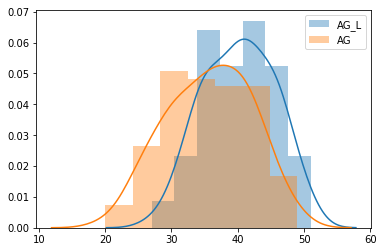

In [72]:
# compare by birth
agl = []
ag = []
for i in range(100):
    agl.append(AG_L2(n=1000, life_threshold=.5, verbose=False))
    ag.append(AG_L2(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

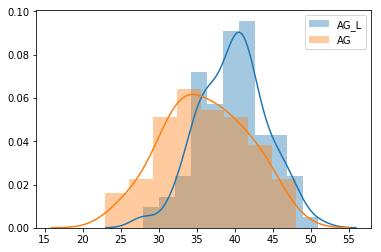

In [70]:
# compare by birth
agl = []
ag = []
for i in range(100):
    agl.append(AG_L2(n=1000,verbose=False))
    ag.append(AG_L2(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

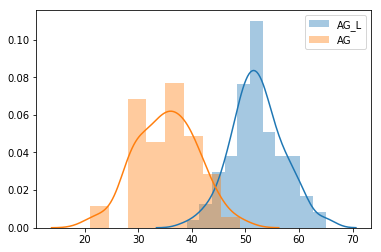

In [30]:
# knows exact lifespans
agl = []
ag = []
for i in range(100):
    agl.append(AG_L2(n=1000,verbose=False))
    ag.append(AG_L2(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

In [9]:
# offline simulation for AG_L
# fast version, consumes much less records
def AG_L(n=1000000,k=1, m=25, life_threshold=.3, records=records, lives=lives, verbose=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    if lives == None: # estimate lifespans using past mean
        
        
        
        
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    
    # initialization
    while t<=m:
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    n_exploit = 0
    n_explore = 0
    while t<=n:
        best = max(X.items(), key= lambda x:x[1][0]/x[1][1])
        X_max = best[1][0]/best[1][1]
        if np.random.binomial(1, min(1, X_max*k)): # exploit
            n_exploit += 1                       
            while i < len(records): # look for target arm
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                if displayed == best[0]:
                    rewards += clicked
                    break
                i += 1
                
        else: # explore
            n_explore += 1           
            while i < len(records):
                displayed = records[i]['displayed']
                clicked = records[i]['clicked']
                time = records[i]['timestamp']
                born = filter(lambda x: x[1][0]<time, lives.items()) # fileter out unborn articles from lives
                life_rank = sorted(born, key= lambda x: x[1][1], reverse= True) # sort born articles by their expiring date
                young = life_rank[ : int(len(life_rank)*life_threshold)] # articles among top $life_threshold$% on the life ranking
                if displayed in list(zip(*young))[0]:
                    rewards += clicked
                    break
                i += 1

        X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
        t += 1
        i += 1
        
    if verbose:
        print('# exploit:', n_exploit)
        print('# explore:', n_explore)
        print('# records:', i)
        print('max expectation:', X_max)
    
    return rewards

In [21]:
AG_L(n=10000)

# exploit: 727
# explore: 9248
# records: 52197
max expectation: 0.06087877183695077


462

In [199]:
AG_L(n=100000)

# exploit: 5584
# explore: 94391
# records: 399813
max expectation: 0.05325370929015576


3836

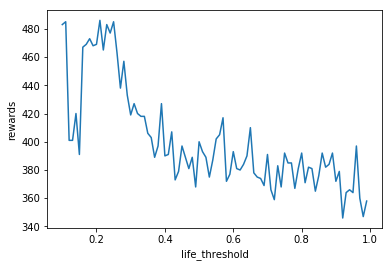

In [35]:
x = []
y = []
for b in np.arange(0.1,1.,.01):
    x.append(b)
    y.append(AG_L(n=10000,life_threshold=b, verbose=False))
plt.plot(x,y)
plt.xlabel('life_threshold')
plt.ylabel('rewards')
pass

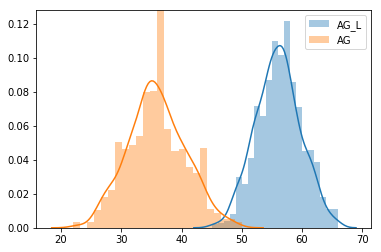

In [84]:
agl = []
ag = []
for i in range(1000):
    agl.append(AG_L(n=1000,verbose=False))
    ag.append(AG_L(n=1000, life_threshold=1, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(agl,label='AG_L')
sns.distplot(ag,label='AG')
plt.legend()
pass

In [5]:
def ucb(x, c, t, S, record, r, lives, mode=True):
    # r: ratio between paces of timestamp and turns
    time = record['timestamp']
    article = x[0]
    acc_reward, T = x[1]
    die = lives[article][1]
    s = S.get(article, t)
    if mode:
        return acc_reward/T + c*np.log(r*(die-time)+1) * np.sqrt(2*np.log(t-s+1) / T)
    else:
        return acc_reward/T + np.sqrt(2*np.log(t-s+1)/T)
    
# offline simulation for AG_L
# fast version, consumes much less records
def UCB_L(n=1000, c=.005, m=25, r=1, records=records, verbose=True, mode=True):
    # records should be long enough
    '''
    n: number of turns to play
    m: number of turns to initialize
    k: adjust desire to exploit/explore
    '''
    global lives # dict of articles to their lifespans
    rewards = 0
    i = 0 # marker in records
    X = {} # dict of expectations article_id : array([sum, n_observations])
    t = 1 # number of turn taken
    S = {}
    # initialization
    while t<=m:
        #print(t,i, flush=True)
        displayed = records[i]['displayed']
        clicked = records[i]['clicked']
        if displayed not in X.keys():
            S[displayed] = t
            X[displayed] = np.array([clicked, 1])
            t += 1
        i += 1
    
    while t<=n:
        while i<len(records):
            fake = False
            displayed = records[i]['displayed']
            clicked = records[i]['clicked']
            
            if displayed not in X.keys():
                fake = True
                estimation = sum(map(lambda x:x[0]/x[1], X.values())) / len(X)
                X[displayed] = np.array([estimation, 1])
                
            
            best = max(X.items(), key= lambda x:ucb(x=x, c=c, t=t, S=S, record=records[i], lives=lives, r=r, mode=mode))
            
            if fake:
                X.pop(displayed)

            if displayed == best[0]:
                rewards += clicked
                if displayed not in S.keys(): # the first time an arm is played
                    S[displayed] = t
                X[displayed] = X.get(displayed, np.array([0, 0])) + np.array([clicked, 1])
                break
            i += 1
        if verbose:       
            if i%1000==0:
                print(t,i)
            
        t += 1
        i += 1
    if verbose:
        print('# X', len(X.keys()))
        print('# records', i)
    
    return rewards

In [ ]:
UCB_L(c=.001, r=1)

In [ ]:
UCB_L(c=.0001, r=1)

In [53]:
UCB_L(n=1000,c=.005)

# X 25
# records 24479


47

In [25]:
UCB_L(n=10000,c=.001)

1235 33000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


1788 48000
2044 54000
2634 67000
2723 69000
3333 83000
5754 141000
6606 160000
6937 167000
7469 1608000
8469 1609000
9469 1610000
# X 25
# records 1610532


319

In [54]:
UCB_L(n=10000, c=.005)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


4417 107000
6337 151000
7622 1608000
8622 1609000
9622 1610000
# X 25
# records 1610379


341

In [23]:
UCB_L(n=10000, c=.0001)

364 9000
510 13000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


2005 52000
2406 61000
2494 63000
4057 100000
6870 164000
7063 168000
7555 1608000
8555 1609000
9555 1610000
# X 25
# records 1610446


231

In [48]:
UCB_L(n=10000, c=.01)

217 5000
1287 33000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


2145 54000
4230 102000
4739 114000
5926 142000
7077 168000
7569 1608000
8569 1609000
9569 1610000
# X 25
# records 1610432


289

In [49]:
UCB_L(n=10000,c=.1)

1200 32000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


2642 67000
4086 100000
4167 102000
5655 136000
5791 139000
6127 147000
7576 1608000
8576 1609000
9576 1610000
# X 25
# records 1610425


297

In [50]:
UCB_L(n=10000,c=1)

693 17000
844 21000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


2968 72000
4865 117000
5778 137000
6199 147000
6419 152000
7631 1608000
8631 1609000
9631 1610000
# X 25
# records 1610370


244

In [51]:
UCB_L(n=10000,c=10)

622 17000
1613 42000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


2709 67000
4938 119000
5813 140000
6321 152000
7550 1608000
8550 1609000
9550 1610000
# X 25
# records 1610451


249

In [52]:
UCB_L(n=10000,c=100)

216 5000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


2546 64000
2649 66000
2691 67000
5534 136000
6038 147000
6253 152000
7517 1608000
8517 1609000
9517 1610000
# X 25
# records 1610484


254

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


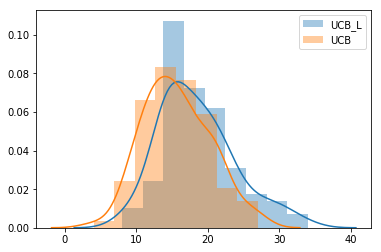

In [55]:
ucbl = []
ucbn = []
for i in range(100):
    ucbl.append(UCB_L(n=500, m=20, r=.5, c=0.005, records=records[i*10000:100000+i*10000], verbose=False))
    ucbn.append(UCB_L(n=500, m=20, r=.5, records=records[i*10000:100000+i*10000], mode=False, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(ucbl,label='UCB_L')
sns.distplot(ucbn,label='UCB')
plt.legend()
pass

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


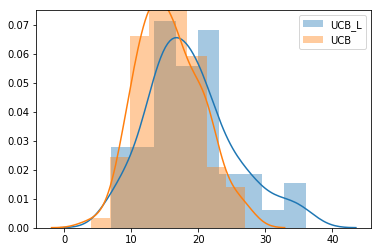

In [57]:
ucbl = []
ucbn = []
for i in range(100):
    ucbl.append(UCB_L(n=500, m=20, r=1, c=0.005, records=records[i*10000:100000+i*10000], verbose=False))
    ucbn.append(UCB_L(n=500, m=20, r=1, c=.005, records=records[i*10000:100000+i*10000], mode=False, verbose=False))
    print(i,end='\r',flush=True)
    time.sleep(.001)
sns.distplot(ucbl,label='UCB_L')
sns.distplot(ucbn,label='UCB')
plt.legend()
pass

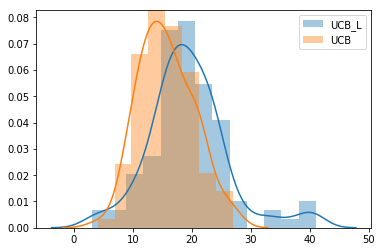

In [27]:
#r=1
sns.distplot(ucbl,label='UCB_L')
sns.distplot(ucbn,label='UCB')
plt.legend()
pass

In [23]:
from collections import Counter

In [25]:
c=Counter()
i=0
while i<len(records):
    c[records[i]['clicked']] += 1
    i += 1
c

Counter({0: 1552903, 1: 54622})

In [28]:
c[1]/(c[0]+c[1])

0.03397894278471563